In [ ]:
# IMPORTS : importing the various libraries needed

import cv2,os,time
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

In [ ]:
# MOUNT DRIVE, CHANGE PATH : mounting the google drive to access the dataset and save the model

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Satellite Image Classification
# !ls
# !unzip 'Satellite Data.zip'

Mounted at /content/drive
/content/drive/MyDrive/Satellite Image Classification


In [ ]:
# INITIALIZE VALUES : initializing some constant values that will be needed throughout the file.

BASE_PATH = 'data'
labels = ['CLOUDY', 'DESERT', 'GREEN ', 'WATER']
class_folder_paths = [BASE_PATH + '/' + x for x in os.listdir(BASE_PATH + '/')]
IMAGE_SIZE = [255, 255]
class_num_dictionary = {
    "cloudy" : 0,
    "desert" : 1,
    "green_area" : 2,
    "water" : 3
}

In [ ]:
# CREATE DATA GENERATORS : data generators will be needed to load the data to the model 
#                          while training and evaluating the model.

train_data_gen = ImageDataGenerator(
                    rescale = 1./255,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    validation_split=0.2
)

test_data_gen = ImageDataGenerator(rescale = 1./255)

training_set = train_data_gen.flow_from_directory(
                BASE_PATH,
                target_size = (255, 255),
                batch_size =32,
                class_mode = 'categorical',
                shuffle=True,
                subset='training'
)
test_set = train_data_gen.flow_from_directory(
                BASE_PATH,
                target_size = (255, 255),
                batch_size =32,
                class_mode = 'categorical',
                shuffle=False,
                subset='validation'
)

Found 4505 images belonging to 4 classes.
Found 1126 images belonging to 4 classes.


In [ ]:
# LOAD MODEL : loading the mobilenet model and making changes according to our required application

mobilenet = mobilenet_v2.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape= IMAGE_SIZE + [3]
)
mobilenet.summary()

for layer in mobilenet.layers:
    layer.trainable =False
x = Flatten()(mobilenet.output)
output = Dense(len(class_folder_paths), activation='softmax')(x)
model = Model(inputs=mobilenet.input, outputs=output)


9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 255, 255, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                

In [ ]:
# SUMMARY : displaying the summary of the model, we have removed the 3 dense layers from the top and have added a single SOFTMAX layer instead.

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 255, 255, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
# COMILE : compiling the model

model.compile(
loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy']
)

In [ ]:
# FIT : Fitting the model on the training data 



early = EarlyStopping( monitor='val_loss', patience=2, restore_best_weights=True)
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)

start_time = time.time()
EPOCHS = 10
model_trained = model.fit(
        training_set,
        validation_data = test_set,
        steps_per_epoch=len(training_set),
        validation_steps=len(test_set),
        callbacks = [early, model_checkpoint_callback], 
        epochs = EPOCHS
)

end_time = time.time()


time_elapsed = end_time - start_time
print(" Time taken per Epoch : " + str(time_elapsed/EPOCHS))

Epoch 1/10
141/141 [==============================] - 3422s 24s/step - loss: 0.3684 - accuracy: 0.9634 - val_loss: 0.2947 - val_accuracy: 0.9600
Epoch 2/10
141/141 [==============================] - 87s 620ms/step - loss: 0.1466 - accuracy: 0.9811 - val_loss: 0.3721 - val_accuracy: 0.9600
Epoch 3/10
141/141 [==============================] - 86s 612ms/step - loss: 0.2314 - accuracy: 0.9780 - val_loss: 0.1504 - val_accuracy: 0.9805
Epoch 4/10
141/141 [==============================] - 86s 609ms/step - loss: 0.1525 - accuracy: 0.9840 - val_loss: 0.2381 - val_accuracy: 0.9831
Epoch 5/10
141/141 [==============================] - 86s 609ms/step - loss: 0.1429 - accuracy: 0.9869 - val_loss: 0.4177 - val_accuracy: 0.9796
 Time taken per Epoch : 378.7608875274658


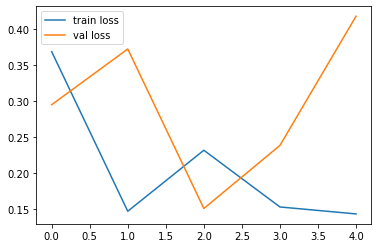

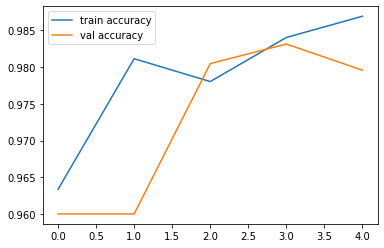

<Figure size 432x288 with 0 Axes>

In [ ]:
# PLOT : Plotting the loss, accuracy at different training epochs.

plt.plot(model_trained.history['loss'], label = 'train loss')
plt.plot(model_trained.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()
plt.savefig('train-val-loss')

plt.plot(model_trained.history['accuracy'], label = 'train accuracy')
plt.plot(model_trained.history['val_accuracy'], label = 'val accuracy')
plt.legend()
plt.show()
plt.savefig('train-val-accuracy')

In [ ]:
# EVALUATE : Evaluate the performance of the model on the testing data.

model.load_weights(checkpoint_filepath)
model.evaluate(test_set)

36/36 [==============================] - 24s 680ms/step - loss: 0.2446 - accuracy: 0.9805


[0.24458687007427216, 0.980461835861206]

In [ ]:
# SAVE : save the model, so that it can be loaded for predictions and evaluations 
#        even after the runtime disconnects.

model.save('MobileNet.h5')

In [ ]:
# LOAD : loading the model for predictions.

model = keras.models.load_model('MobileNet.h5')

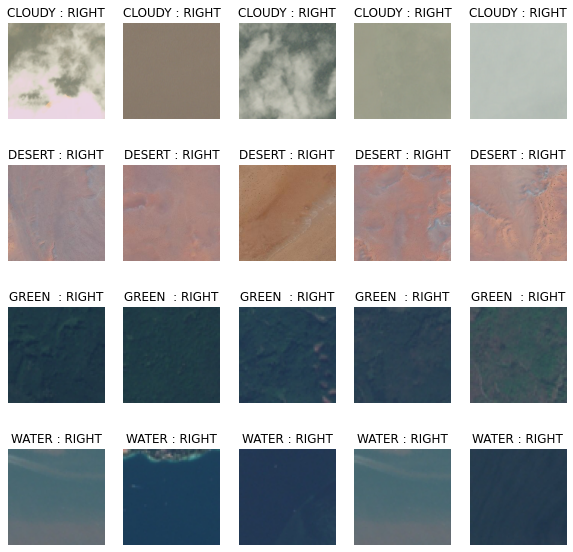

In [ ]:
# PREDICT : using the model to predict the class of 25
#           randomly selected images and plotting the images
#           along with their predictions, and a test displaying 
#           whether the predictions were correct or not.

image_list = []
label_list = []

class_num_dictionary = {
    "cloudy" : 0,
    "desert" : 1,
    "green_area" : 2,
    "water" : 3
}
for cur_class in os.listdir(BASE_PATH):
  path = os.path.join(BASE_PATH, cur_class)
  count = 0
  cur_list = os.listdir(path)
  for i in np.random.randint(1, len(cur_list), 5, dtype=int):
    cur_image_path = cur_list[i]
    image_list.append(os.path.join(BASE_PATH,cur_class,cur_image_path))
    label_list.append(class_num_dictionary[cur_class])
    count += 1
    if(count == 5): break

plt.figure(figsize=(10,10))
for i in range(20):

  plt.subplot(4,5,i+1)
  
  img_path = image_list[i]
  label = label_list[i]
   
  img = mpimg.imread(img_path)
  plt.imshow(img)
  
  
  img = image.load_img(img_path,target_size = IMAGE_SIZE)
  img_array = image.img_to_array(img)
  img_array = img_array * 1./255
  img_batch = np.expand_dims(img_array,axis = 0)
  prediction = np.argmax(model.predict(img_batch))

  cur_title = labels[label]
  if label == prediction : 
    cur_title += " : RIGHT"
  else:
    cur_title += " : WRONG"
  plt.title(cur_title)
  plt.axis("off")
plt.show()

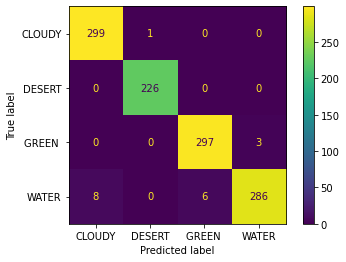

In [ ]:
# CONFUSION MATRIX : plotting the confusion matrix


Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_set.classes, y_pred)
mat = ConfusionMatrixDisplay(cm,display_labels=labels)
mat.plot()

In [ ]:
# CLASSIFICATION REPORT 

print(classification_report(test_set.classes, y_pred, target_names=labels))

              precision    recall  f1-score   support

      CLOUDY       0.97      1.00      0.99       300
      DESERT       1.00      1.00      1.00       226
      GREEN        0.98      0.99      0.99       300
       WATER       0.99      0.95      0.97       300

    accuracy                           0.98      1126
   macro avg       0.98      0.98      0.98      1126
weighted avg       0.98      0.98      0.98      1126

